In [45]:
# testing matching ground-truth boxes to proposal boxes.
from pfa import get_test_data
from detectron2.structures import Boxes, Instances, pairwise_iou
from detectron2.modeling.matcher import Matcher
from detectron2.utils.visualizer import Visualizer
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.modeling import build_model


In [46]:
# load data 
test_data = get_test_data()

In [47]:
test_image = test_data[0]

boxes = Boxes(torch.tensor(np.vstack([annotation["bbox"] for annotation in test_image["annotations"]])))
classes = np.array([annotation["category_id"] for annotation in test_image["annotations"]])


In [48]:
gt_classes

array([93, 16, 11, 76, 28, 93, 89,  9,  6, 28, 18,  5,  5, 11, 24, 42])

In [49]:
boxes.tensor

tensor([[  42.,    0.,  216.,  150.],
        [ 261.,   21.,  483.,  159.],
        [ 510.,   57.,  768.,  174.],
        [ 804.,   27.,  948.,  177.],
        [ 978.,   54., 1203.,  189.],
        [1236.,   79., 1389.,  229.],
        [   0.,  202.,  159.,  379.],
        [ 207.,  187.,  375.,  385.],
        [ 426.,  214.,  582.,  316.],
        [ 627.,  208.,  837.,  322.],
        [ 876.,  202., 1071.,  337.],
        [1137.,  232., 1329.,  334.],
        [  12.,  370.,  192.,  481.],
        [ 342.,  370.,  570.,  493.],
        [ 615.,  343.,  807.,  463.],
        [ 879.,  340., 1077.,  475.]])

In [7]:
match_quality_matrix = pairwise_iou(boxes, boxes)

In [8]:
# build matcher
matcher = Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=False)

In [9]:
matched_idxs, matched_labels = matcher(match_quality_matrix)

In [10]:
matched_idxs

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [11]:
matched_labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int8)

In [50]:
# extract bboxes directly from the image
img = cv2.imread(test_data[0]["file_name"])
img.shape

(493, 1389, 3)

In [16]:
test_data[0]["height"], test_data[0]["width"] 

(493, 1389)

In [21]:
test_bbox = test_image["annotations"][0]["bbox"]
test_bbox = [int(coord) for coord in test_bbox]

In [31]:
test_bbox

[42, 0, 216, 150]

In [29]:
hotspot = img[test_bbox[1]:test_bbox[3], test_bbox[0]:test_bbox[2]]
hospot_rgb = cv2.cvtColor(hotspot, cv2.COLOR_BGR2RGB) 

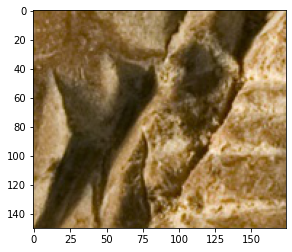

In [30]:
plt.imshow(hospot_rgb)

In [51]:
cfg = get_cfg()
# using full network - may just be a way to just use RPN
cfg.merge_from_file("singlescale.yml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

In [52]:
outputs = predictor(img)  

In [53]:
len(outputs["instances"].pred_boxes)

65

In [54]:
pred_boxes = outputs["instances"].pred_boxes

In [55]:
pred_boxes

Boxes(tensor([[8.8136e+02, 2.1377e+02, 1.0579e+03, 3.3114e+02],
        [1.8513e+02, 1.9069e+02, 3.5302e+02, 3.4208e+02],
        [5.9294e+02, 3.5463e+02, 8.1543e+02, 4.8742e+02],
        [5.1719e+02, 3.3004e+01, 7.9340e+02, 1.8859e+02],
        [1.1382e+03, 2.3356e+02, 1.2801e+03, 3.3495e+02],
        [2.6628e+01, 1.4381e+01, 1.9591e+02, 1.3767e+02],
        [6.3722e+02, 2.1755e+02, 8.2202e+02, 3.4856e+02],
        [1.2597e+03, 1.1677e+02, 1.3890e+03, 2.3404e+02],
        [7.9011e+02, 3.3659e+01, 9.7269e+02, 1.9392e+02],
        [4.0888e+02, 2.1539e+02, 5.6805e+02, 3.3257e+02],
        [8.3070e+02, 3.4964e+02, 1.0660e+03, 4.7837e+02],
        [9.7469e+02, 9.0162e+01, 1.2161e+03, 1.7985e+02],
        [7.9866e+02, 3.3093e+01, 9.8103e+02, 1.7894e+02],
        [6.1139e+02, 2.1846e+02, 8.4491e+02, 3.4512e+02],
        [2.4686e+02, 2.0241e+00, 4.6725e+02, 1.7438e+02],
        [8.9995e+02, 1.9855e+02, 1.0860e+03, 3.3926e+02],
        [3.5432e+02, 3.4584e+02, 5.5321e+02, 4.8468e+02],
        

In [100]:
class ClassesPredictor(DefaultPredictor):
    def __call__(self, original_image):
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            #predictions = self.model([inputs])[0]
            images = self.model.preprocess_image([inputs])
            features = self.model.backbone(images.tensor)
            proposals, _ = self.model.proposal_generator(images, features, None)

            # pred_instances = self.model.roi_heads._forward_box(features, proposals)
            # During inference cascaded prediction is used: the mask and keypoints heads are only
            # applied to the top scoring box detections.
            # pred_instances = self.model.roi_heads.forward_with_given_boxes(features, pred_instances)

            features = [features[f] for f in self.model.roi_heads.box_in_features]
            box_features = self.model.roi_heads.box_pooler(features, [x.proposal_boxes for x in proposals])
            box_features = self.model.roi_heads.box_head(box_features)
            predictions = self.model.roi_heads.box_predictor(box_features)
            del box_features

            scores = self.model.roi_heads.box_predictor.predict_probs(predictions, proposals)

            # pred_instances, _ = self.model.roi_heads.box_predictor.inference(predictions, proposals)

            # results, _ = self.model.roi_heads(images, features, proposals, None)

            return scores


In [101]:
modpredictor = ClassesPredictor(cfg)
modoutputs = modpredictor(img)  

In [110]:
filter_mask = modoutputs[0] > 0.3

In [112]:
filter_inds = filter_mask.nonzero()

In [113]:
filter_inds.shape

torch.Size([206, 2])

In [67]:
def get_hotspots(image, boxes, matcher=None, gt_boxes=None, gt_classes=None):
    # extracts invididual hotspot instances from predicted regions.
    # optionally, aligns them to existing gt and produce groundtruth classes 
    # from the full class set. 
    # TODO: determine best way to deal with false positives. 

    # extract hotspot for each bbox in instances

    hotspots = []
    for i in range(len(boxes)):
        bbox = [int(v) for v in boxes.tensor[i,:].tolist()]
        hotspot = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        hotspots.append(hotspot)

    if gt_boxes is None:
        return hotspots

    match_quality_matrix = pairwise_iou(gt_boxes, boxes)
    matched_idxs, matched_labels = matcher(match_quality_matrix)

    # compute ground-truth classes for every box
    aligned_classes = gt_classes[matched_idxs]
    # handle background classes
    aligned_classes[matched_labels==0] = -1

    return hotspots, aligned_classes

In [66]:
hotspots, classes = get_hotspots(img, 
                                pred_boxes.to("cpu"), 
                                matcher=Matcher([0.3, 0.7], [0, -1, 1], allow_low_quality_matches=False), 
                                gt_boxes=boxes.to("cpu"), gt_classes=classes)

tensor([10,  7, 14,  2, 11,  0,  9,  5,  3,  8, 15,  4,  3,  9,  1, 10, 13, 12,
        12, 13,  8,  2,  6,  4, 13,  0,  1,  1, 15,  4, 12, 12,  4, 11,  4,  8,
        14,  1,  2,  4, 15, 12,  6, 12, 13,  6, 15,  5,  1, 15,  0,  5, 15,  2,
        11, 14, 10, 13,  7, 12,  9, 14,  4,  7, 15])


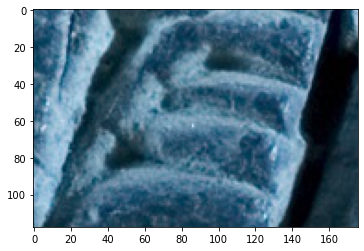

In [69]:
plt.imshow(hotspots[0])

In [70]:
classes

array([18,  9, 24, 11,  5, 93, 28, 93, 76,  6, 42, 28, 76, 28, 16, 18, 11,
        5,  5, 11,  6, 11, 89, -1, 11, 93, 16, 16, 42, 28,  5,  5, 28,  5,
       28,  6, 24, 16, 11, 28, 42,  5, 89,  5, -1, 89, 42, 93, 16, 42, 93,
       93, 42, 11,  5, 24, 18, -1,  9,  5, 28, 24, 28,  9, 42])

In [71]:
gt_classes

array([93, 16, 11, 76, 28, 93, 89,  9,  6, 28, 18,  5,  5, 11, 24, 42])